In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 4

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

In [2]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_regr = self.regress(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

Epoch 1/50
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3440 - classifier_out_loss: 2.2677 - decoder_out_loss: 0.0249 - regressor_out_loss: 20.5694 - classifier_out_accuracy: 0.1312 - decoder_out_accuracy: 0.9515 - regressor_out_accuracy: 0.6570 - val_loss: 0.1639 - val_classifier_out_loss: 2.1075 - val_decoder_out_loss: 0.0158 - val_regressor_out_loss: 4.2730 - val_classifier_out_accuracy: 0.2130 - val_decoder_out_accuracy: 0.9518 - val_regressor_out_accuracy: 0.9435
Epoch 2/50
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1353 - classifier_out_loss: 1.8748 - decoder_out_loss: 0.0138 - regressor_out_loss: 2.7755 - classifier_out_accuracy: 0.2785 - decoder_out_accuracy: 0.9481 - regressor_out_accuracy: 0.9675 - val_loss: 0.1250 - val_classifier_out_loss: 1.7546 - val_decoder_out_loss: 0.0131 - val_regressor_out_loss: 2.4193 - val_classifier_out_accuracy: 0.2950 - val_decoder_out_accuracy: 0.9483 - val_regressor_out_accuracy: 0.9537
Epoch 3

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

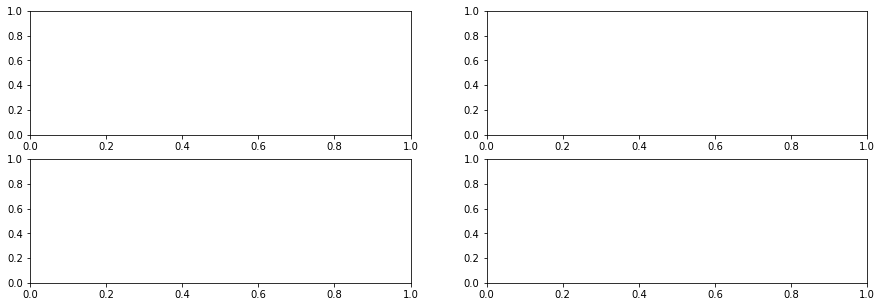

In [5]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.05,
    'regressor_out' : 0.01
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)


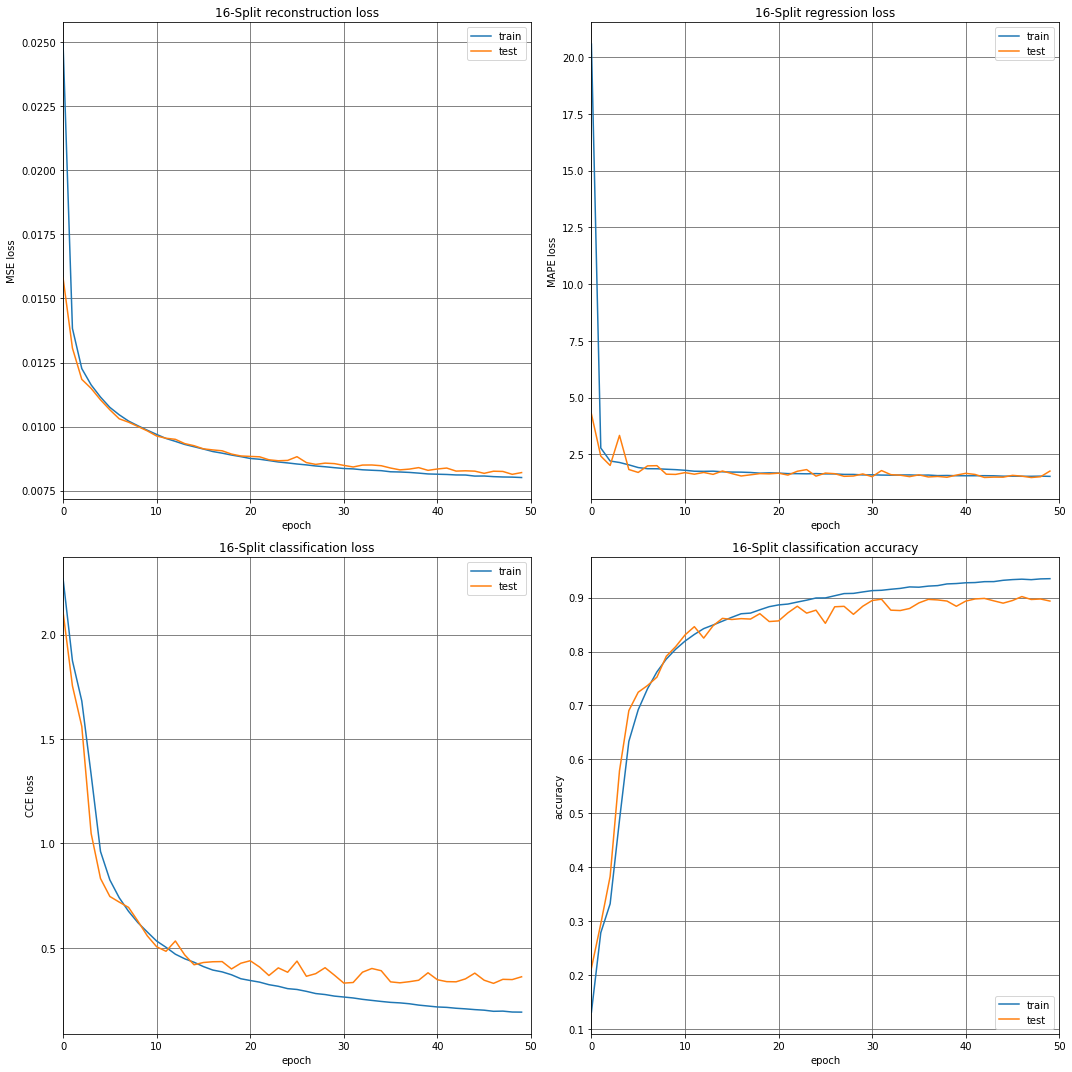

In [8]:
import matplotlib.pyplot as plt

model.save_weights('../weights/43_CAE4x16_reco+regr+class_epoch50_weights.h5')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axes[0][0].set_title('16-Split reconstruction loss')
axes[0][0].plot(history.history['decoder_out_loss'])
axes[0][0].plot(history.history['val_decoder_out_loss'])
axes[0][0].set_ylabel('MSE loss')
axes[0][0].set_xlabel('epoch')
axes[0][0].set_xlim((0,50))
axes[0][0].grid(b=True, which='major', color='#666666', linestyle='-')
axes[0][0].legend(['train', 'test'], loc='upper right')

axes[0][1].set_title('16-Split regression loss')
axes[0][1].plot(history.history['regressor_out_loss'])
axes[0][1].plot(history.history['val_regressor_out_loss'])
axes[0][1].set_ylabel('MAPE loss')
axes[0][1].set_xlabel('epoch')
axes[0][1].set_xlim((0,50))
axes[0][1].grid(b=True, which='major', color='#666666', linestyle='-')
axes[0][1].legend(['train', 'test'], loc='upper right')

axes[1][0].set_title('16-Split classification loss')
axes[1][0].plot(history.history['classifier_out_loss'])
axes[1][0].plot(history.history['val_classifier_out_loss'])
axes[1][0].set_ylabel('CCE loss')
axes[1][0].set_xlabel('epoch')
axes[1][0].set_xlim((0,50))
axes[1][0].grid(b=True, which='major', color='#666666', linestyle='-')
axes[1][0].legend(['train', 'test'], loc='upper right')

axes[1][1].set_title('16-Split classification accuracy')
axes[1][1].plot(history.history['classifier_out_accuracy'])
axes[1][1].plot(history.history['val_classifier_out_accuracy'])
axes[1][1].set_ylabel('accuracy')
axes[1][1].set_xlabel('epoch')
axes[1][1].set_xlim((0,50))
axes[1][1].grid(b=True, which='major', color='#666666', linestyle='-')
axes[1][1].legend(['train', 'test'], loc='lower right')

fig.tight_layout()
plt.savefig('../img/43_PLOTS/16split_regr+class+reco_loss.png', dpi=200)


In [9]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0,
    'regressor_out' : 0.01
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

model.save_weights('../weights/43_CAE4x16_reco+regr_epoch50_weights.h5')

Epoch 1/50
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0906 - classifier_out_loss: 2.3242 - decoder_out_loss: 0.0181 - regressor_out_loss: 7.2444 - classifier_out_accuracy: 0.0966 - decoder_out_accuracy: 0.9498 - regressor_out_accuracy: 0.9047 - val_loss: 0.0451 - val_classifier_out_loss: 2.3195 - val_decoder_out_loss: 0.0133 - val_regressor_out_loss: 3.1763 - val_classifier_out_accuracy: 0.0986 - val_decoder_out_accuracy: 0.9447 - val_regressor_out_accuracy: 0.9573
Epoch 2/50
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0396 - classifier_out_loss: 2.3200 - decoder_out_loss: 0.0123 - regressor_out_loss: 2.7311 - classifier_out_accuracy: 0.0973 - decoder_out_accuracy: 0.9467 - regressor_out_accuracy: 0.9689 - val_loss: 0.0326 - val_classifier_out_loss: 2.3184 - val_decoder_out_loss: 0.0117 - val_regressor_out_loss: 2.0882 - val_classifier_out_accuracy: 0.0959 - val_decoder_out_accuracy: 0.9474 - val_regressor_out_accuracy: 0.9686
Epoch 3/

In [10]:
for layer in model.encoder.layers:
    layer.trainable = False
for layer in model.regressor.layers:
    layer.trainable = False
for layer in model.decoder.layers:
    layer.trainable = False
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 0.0,
    'classifier_out' : 1.0,
    'regressor_out' : 0.0
}

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

Epoch 1/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0186 - classifier_out_loss: 2.3117 - decoder_out_loss: 0.0066 - regressor_out_loss: 1.1925 - classifier_out_accuracy: 0.0947 - decoder_out_accuracy: 0.9511 - regressor_out_accuracy: 0.9900 - val_loss: 0.0196 - val_classifier_out_loss: 2.3115 - val_decoder_out_loss: 0.0067 - val_regressor_out_loss: 1.2870 - val_classifier_out_accuracy: 0.0939 - val_decoder_out_accuracy: 0.9508 - val_regressor_out_accuracy: 0.9892
Epoch 2/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0186 - classifier_out_loss: 2.3117 - decoder_out_loss: 0.0066 - regressor_out_loss: 1.1925 - classifier_out_accuracy: 0.0947 - decoder_out_accuracy: 0.9511 - regressor_out_accuracy: 0.9900 - val_loss: 0.0196 - val_classifier_out_loss: 2.3115 - val_decoder_out_loss: 0.0067 - val_regressor_out_loss: 1.2870 - val_classifier_out_accuracy: 0.0939 - val_decoder_out_accuracy: 0.9508 - val_regressor_out_accuracy: 0.9892
Epoch 3/50

In [3]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.005,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.load_weights('../weights/43_CAE4x16_reco+class_epoch50_weights.h5')
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

model.save_weights('../weights/43_CAE4x16_reco+class_epoch50_weights.h5')

Epoch 1/50
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0255 - classifier_out_loss: 1.6987 - decoder_out_loss: 0.0170 - regressor_out_loss: 99.7465 - classifier_out_accuracy: 0.3708 - decoder_out_accuracy: 0.9493 - regressor_out_accuracy: 0.5270 - val_loss: 0.0172 - val_classifier_out_loss: 1.0557 - val_decoder_out_loss: 0.0119 - val_regressor_out_loss: 99.8491 - val_classifier_out_accuracy: 0.6359 - val_decoder_out_accuracy: 0.9470 - val_regressor_out_accuracy: 0.5258
Epoch 2/50
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0157 - classifier_out_loss: 0.9455 - decoder_out_loss: 0.0110 - regressor_out_loss: 99.8459 - classifier_out_accuracy: 0.6640 - decoder_out_accuracy: 0.9470 - regressor_out_accuracy: 0.5394 - val_loss: 0.0144 - val_classifier_out_loss: 0.8148 - val_decoder_out_loss: 0.0103 - val_regressor_out_loss: 99.8545 - val_classifier_out_accuracy: 0.7133 - val_decoder_out_accuracy: 0.9483 - val_regressor_out_accuracy: 0.5308
Epoc

In [5]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 0.0,
    'classifier_out' : 0.0,
    'regressor_out' : 1.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
for layer in model.encoder.layers:
    layer.trainable = False
for layer in model.classifier.layers:
    layer.trainable = False
for layer in model.decoder.layers:
    layer.trainable = False
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

# model.save_weights('../weights/43_CAE4x16_reco+regr_epoch50_weights.h5')

Epoch 1/50
1875/1875 [==============================] - 16s 8ms/step - loss: 28.5595 - classifier_out_loss: 2.3148 - decoder_out_loss: 0.2430 - regressor_out_loss: 28.5595 - classifier_out_accuracy: 0.0904 - decoder_out_accuracy: 0.7772 - regressor_out_accuracy: 0.5000 - val_loss: 27.6305 - val_classifier_out_loss: 2.3154 - val_decoder_out_loss: 0.2430 - val_regressor_out_loss: 27.6305 - val_classifier_out_accuracy: 0.0892 - val_decoder_out_accuracy: 0.7769 - val_regressor_out_accuracy: 0.4886
Epoch 2/50
1875/1875 [==============================] - 16s 9ms/step - loss: 27.4794 - classifier_out_loss: 2.3148 - decoder_out_loss: 0.2430 - regressor_out_loss: 27.4794 - classifier_out_accuracy: 0.0904 - decoder_out_accuracy: 0.7772 - regressor_out_accuracy: 0.4968 - val_loss: 27.5024 - val_classifier_out_loss: 2.3154 - val_decoder_out_loss: 0.2430 - val_regressor_out_loss: 27.5024 - val_classifier_out_accuracy: 0.0892 - val_decoder_out_accuracy: 0.7769 - val_regressor_out_accuracy: 0.4886
Ep

In [3]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 0.0,
    'classifier_out' : 1.0,
    'regressor_out' : 1.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
# model.load_weights('../weights/43_CAE4x16_reco+class_epoch50_weights.h5')
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

model.save_weights('../weights/43_CAE4x16_regr+class_epoch50_weights.h5')

Epoch 1/50
1875/1875 [==============================] - 26s 14ms/step - loss: 6.4514 - classifier_out_loss: 0.5773 - decoder_out_loss: 0.0155 - regressor_out_loss: 5.8741 - classifier_out_accuracy: 0.8222 - decoder_out_accuracy: 0.9495 - regressor_out_accuracy: 0.9345 - val_loss: 3.2661 - val_classifier_out_loss: 0.4446 - val_decoder_out_loss: 0.0173 - val_regressor_out_loss: 2.8215 - val_classifier_out_accuracy: 0.8559 - val_decoder_out_accuracy: 0.9493 - val_regressor_out_accuracy: 0.9616
Epoch 2/50
1875/1875 [==============================] - 26s 14ms/step - loss: 2.9386 - classifier_out_loss: 0.4422 - decoder_out_loss: 0.0170 - regressor_out_loss: 2.4964 - classifier_out_accuracy: 0.8533 - decoder_out_accuracy: 0.9493 - regressor_out_accuracy: 0.9716 - val_loss: 2.4885 - val_classifier_out_loss: 0.4505 - val_decoder_out_loss: 0.0171 - val_regressor_out_loss: 2.0379 - val_classifier_out_accuracy: 0.8540 - val_decoder_out_accuracy: 0.9491 - val_regressor_out_accuracy: 0.9713
Epoch 3/

In [4]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
for layer in model.encoder.layers:
    layer.trainable = False
for layer in model.classifier.layers:
    layer.trainable = False
for layer in model.regressor.layers:
    layer.trainable = False
    
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

Epoch 1/50
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0273 - classifier_out_loss: 2.3183 - decoder_out_loss: 0.0273 - regressor_out_loss: 99.6137 - classifier_out_accuracy: 0.1022 - decoder_out_accuracy: 0.9516 - regressor_out_accuracy: 0.4812 - val_loss: 0.0257 - val_classifier_out_loss: 2.3194 - val_decoder_out_loss: 0.0257 - val_regressor_out_loss: 99.6135 - val_classifier_out_accuracy: 0.1010 - val_decoder_out_accuracy: 0.9518 - val_regressor_out_accuracy: 0.4762
Epoch 2/50
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0253 - classifier_out_loss: 2.3183 - decoder_out_loss: 0.0253 - regressor_out_loss: 99.6138 - classifier_out_accuracy: 0.1022 - decoder_out_accuracy: 0.9522 - regressor_out_accuracy: 0.4812 - val_loss: 0.0256 - val_classifier_out_loss: 2.3194 - val_decoder_out_loss: 0.0256 - val_regressor_out_loss: 99.6135 - val_classifier_out_accuracy: 0.1010 - val_decoder_out_accuracy: 0.9518 - val_regressor_out_accuracy: 0.4762
Epoc